<a href="https://colab.research.google.com/github/Catatau52/Challenge_Data-Science/blob/main/Challenge_DS_Week02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Criando Sessão do Spark

In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

#Montando o Drive e carregando dados

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile

In [8]:
zipfile.ZipFile('/content/drive/MyDrive/curso-spark/Challenge-DS/semana-2.zip', 'r').extractall('/content/drive/MyDrive/curso-spark/Challenge-DS')

In [9]:
dados = spark.read.parquet(
    '/content/drive/MyDrive/curso-spark/Challenge-DS/dataset_transformado_parquet'
)

#Explorando Dados

In [10]:
dados.show(truncate=False)

+------------------------------------+-----+----------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+------+------------+------------+-----------+----+-----------------------+------------+----------+----+-----+------+
|id                                  |andar|area_total|area_util|banheiros|caracteristicas                                                                                                                          |quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso   |vaga|bairro                 |zona        |condominio|iptu|tipo |valor |
+------------------------------------+-----+----------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+------+------------+------------+-----------+----+-----------------------+------------+----------+----+

In [11]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



#Analisando e Tradandos os dados

Verificando que existem colunas que possui o mesmo valor.

In [12]:
dados.count()

66562

In [13]:
dados.filter("tipo == 'Venda'").count()

66562

In [14]:
dados = dados.drop('tipo_anuncio', 'tipo_uso','tipo_unidade','tipo')
dados.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|   1|    Realengo|  Zona Oeste|       285|null| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|1fa1c1e5-e98c-433...|    4|      null|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|      null|null|115000|
|a6ab01ae-3d40-40e...|    2|      null|       55|        1|                  []|      2|     0|   0|

In [15]:
from pyspark.sql import functions as f

Contando quantos "null" existem em cada coluna

In [16]:
dados\
    .select([f.count(f.when(f.isnull(c), True)).alias(c) for c in dados.columns])\
    .show()

+---+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|  0|    0|      9194|        0|        0|              0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



Como 'area_total' e 'area_util' tem valores parecidos, porém 'area_total' possui mais valores nulos. iremos excluir.

In [17]:
dados = dados.drop('area_total')

In [18]:
dados.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+----+------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|iptu| valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+----+------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|  null|   1|            Realengo|  Zona Oeste|       285|null| 22999|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                  []|      2|     0|   0|               Irajá|  Zona Norte|       170|   0|110000|
|1fa1c1e5-e98c-433...|    4|       55|        1|                  []|      2|     0|   1|              Cosmos|  Zona Oeste|      null|null|115000|
|a6ab01ae-3d40-40e...|    2|       55|        1|                  []|      2|     0|   0|        Tomás Coelho|  Zona N

#Convertendo dados

In [19]:
from pyspark.sql.types import IntegerType, DoubleType

In [20]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



Podemos converter o tipo de colunas numéricas, como "andar", "banheiros", "suites" e "quartos" para o tipo inteiro. Além disso também pode ser necessário converter as colunas "area_util", "condominio", "iptu" e "valor" para o tipo double.

In [21]:
dados = dados\
    .withColumn('andar', dados['andar'].cast(IntegerType()))\
    .withColumn('banheiros', dados['banheiros'].cast(IntegerType()))\
    .withColumn('suites', dados['suites'].cast(IntegerType()))\
    .withColumn('quartos', dados['quartos'].cast(IntegerType()))\
    .withColumn('area_util', dados['area_util'].cast(DoubleType()))\
    .withColumn('condominio', dados['condominio'].cast(DoubleType()))\
    .withColumn('iptu', dados['iptu'].cast(DoubleType()))\
    .withColumn('valor', dados['valor'].cast(DoubleType()))
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



#Tratando dados faltantes

In [22]:
from pyspark.sql import functions as f

In [23]:
dados.show(10)

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+------+--------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|  iptu|   valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+------+--------+
|03a386b6-7ab8-4ef...|    0|     43.0|        1|[Churrasqueira, A...|      2|  null|   1|            Realengo|  Zona Oeste|     285.0|  null| 22999.0|
|1fe78d41-b8e0-4d2...|    0|     44.0|        1|                  []|      2|     0|   0|               Irajá|  Zona Norte|     170.0|   0.0|110000.0|
|1fa1c1e5-e98c-433...|    4|     55.0|        1|                  []|      2|     0|   1|              Cosmos|  Zona Oeste|      null|  null|115000.0|
|a6ab01ae-3d40-40e...|    2|     55.0|        1|                  []|      2|     0|   0|     

In [24]:
#dados.select([f.count(f.when(f.isnull(c),1)).alias(c) for c in dados.columns]).show()
dados.select([f.count(f.when(f.isnull(c), True)).alias(c) for c in dados.columns]).show()
#dados.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dados.columns]).show()

+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|              0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [25]:
#dados.select('*').na.fill(0).show(5,truncate=False)
dados = dados.na.fill(value=0,subset=['suites','vaga','condominio','iptu'])

In [26]:
dados.select([f.count(f.when(f.isnull(c), True)).alias(c) for c in dados.columns]).show()

+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|              0|      0|     0|   0|     0|   0|         0|   0|    0|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [27]:
dados.show(10,truncate=False)

+------------------------------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-------+------+----+-----------------------+------------+----------+------+--------+
|id                                  |andar|area_util|banheiros|caracteristicas                                                                                                                |quartos|suites|vaga|bairro                 |zona        |condominio|iptu  |valor   |
+------------------------------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-------+------+----+-----------------------+------------+----------+------+--------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43.0     |1        |[Churrasqueira, Academia, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 24

As listas vazias de 'caracteristicas' ainda precisam ser tratadas

#Tratando a coluna características

In [28]:
from pyspark.sql.functions import explode


In [29]:
dados.select(dados.id,explode(dados.caracteristicas))\
      .select("col")\
      .distinct()\
      .show()

+------------------+
|               col|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|     Churrasqueira|
+------------------+



In [30]:
dados.select(dados.id,explode(dados.caracteristicas)).show(10,truncate=False)

+------------------------------------+------------------+
|id                                  |col               |
+------------------------------------+------------------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Churrasqueira     |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Academia          |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Playground        |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Salão de festas   |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Condomínio fechado|
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Portão eletrônico |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Portaria 24h      |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Animais permitidos|
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Condomínio fechado|
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Portaria 24h      |
+------------------------------------+------------------+
only showing top 10 rows



In [31]:
dados_caract = dados.select(dados.id,explode(dados.caracteristicas))

Extraindo variáveis Dummy e agrupando pela variável id

In [32]:
dados_caract=dados_caract.groupBy("id")\
        .pivot('col')\
        .agg(f.lit(1))\
        .na\
        .fill(0)
dados_caract.show(10,truncate=False)

+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416a-9f84-29091cefe14c|1       |1                 |1            |1                 |1       |1      |1         |1           |1                |1              |
|bfffedfe-99e7-4aed-9a9f-f766225a0f1f|0       |1                 |1            |1                 |1       |0      |1         |0           |1                |1              |
|fcb67af3-5601-415f-9d1f-75280923a4e3|1       |1                 |1            |0                 |0       |1      |1        

Inserindo as colunas no dataset e excluindo a coluna caracteristicas

In [33]:
dados=dados\
    .join(dados_caract, 'id', how='left').drop('caracteristicas')
dados.show(10,truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+-----------------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro                 |zona        |condominio|iptu  |valor   |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+-----+---------+---------+-------+------+----+-----------------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43.0     |1        |2      |0     |1   |Realengo               |Zona Oeste  |285.0     |0.0   |22999.

In [34]:
dados\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dados.columns])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|        0|        0|      0|     0|   0|     0|   0|         0|   0|    0|   12736|             12736|        12736|             12736|   12736|  12736|     12736|       12736|            12736|          12736|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------

In [35]:
dados=dados\
    .select('*')\
    .na\
    .fill(0)

In [36]:
dados\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dados.columns])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|        0|        0|      0|     0|   0|     0|   0|         0|   0|    0|       0|                 0|            0|                 0|       0|      0|         0|           0|                0|              0|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------

#Tratando a coluna zona

In [37]:
dados.select(dados.zona).distinct().show()

+------------+
|        zona|
+------------+
|  Zona Norte|
|  Zona Oeste|
|Zona Central|
|    Zona Sul|
|            |
+------------+



In [38]:
dados_zonas = dados.groupBy('id').pivot('zona').agg(f.lit(1)).fillna(0)

In [39]:
dados_zonas = dados_zonas.drop('')
dados_zonas.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows



Inserindo as colunas no dataset e excluindo a coluna zonas

In [40]:
dados=dados\
    .join(dados_zonas, 'id', how='left').drop('zona')
dados.show(10,truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+-----------------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro                 |condominio|iptu  |valor   |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+------------------------------------+-----+---------+---------+-------+------+----+-----------------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43.0    

#Preparação dos dados para machine learning

In [41]:
dados\
    .select('bairro')\
    .groupBy('bairro')\
    .count()\
    .show()

+-------------------+-----+
|             bairro|count|
+-------------------+-----+
|             Cocotá|   16|
|       Tomás Coelho|   38|
|              Gávea|  597|
|            Ipanema| 2113|
|           Realengo|   46|
|      Gardênia Azul|    7|
|      Bento Ribeiro|   33|
|              Rocha|   38|
|Vicente de Carvalho|   86|
|         Manguinhos|    1|
|       Campo Grande|  639|
|        Jacarepaguá| 4437|
|               Leme|  234|
|           Botafogo| 3499|
|       Padre Miguel|   15|
|       Santo Cristo|  357|
|           Flamengo| 1378|
|  Engenho da Rainha|   25|
| Pedra de Guaratiba|   12|
|            Piedade|  104|
+-------------------+-----+
only showing top 20 rows



A coluna 'bairro' possui muitas variáveis, e para essa quantidade será irrelevante.

In [42]:
dados=dados.drop('bairro')

In [43]:
dados.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [44]:
dados=dados\
      .withColumnRenamed("Animais permitidos","Animais_permitidos")\
      .withColumnRenamed("Condomínio fechado","Condominio_fechado")\
      .withColumnRenamed("Portaria 24h","Portaria_24h")\
      .withColumnRenamed("Portão eletrônico","Portao_eletronico")\
      .withColumnRenamed("Salão de festas","Salao_festas")\
      .withColumnRenamed("Zona Norte","Zona_Norte")\
      .withColumnRenamed("Zona Sul","Zona_Sul")\
      .withColumnRenamed("Zona Oeste","Zona_Oeste")\
      .withColumnRenamed("Zona Central","Zona_Central")

In [45]:
dados.write.parquet(
    path='/content/drive/MyDrive/curso-spark/Challenge-DS/dados_parquet',
    mode='overwrite'
)

#Preparação dos dados para os algoritmos do Spark MLlib

In [49]:
from pyspark.ml.feature import VectorAssembler

In [50]:
dataset = spark.read.parquet('/content/drive/MyDrive/curso-spark/Challenge-DS/dados_parquet/part-00000-23e5fb8e-d29c-4e7c-9c21-c8b6f8fa7df9-c000.snappy.parquet')

In [51]:
dataset.show(5)
     

+--------------------+-----+---------+---------+-------+------+----+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|condominio|  iptu|   valor|Academia|Animais_permitidos|Churrasqueira|Condominio_fechado|Elevador|Piscina|Playground|Portaria_24h|Portao_eletronico|Salao_festas|Zona_Central|Zona_Norte|Zona_Oeste|Zona_Sul|
+--------------------+-----+---------+---------+-------+------+----+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+
|03a386b6-7ab8-4ef...|    0|     43.0|        1|      2|     0|   1|     285.0|   0.0| 22999.0|       1|                 1|            1|                 1|       0|      0|        

Renomeando "valor" para "label"

In [52]:
dataset = dataset.withColumnRenamed('valor', 'label')
dataset = dataset.drop('id')

In [53]:
dataset.columns

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'label',
 'Academia',
 'Animais_permitidos',
 'Churrasqueira',
 'Condominio_fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria_24h',
 'Portao_eletronico',
 'Salao_festas',
 'Zona_Central',
 'Zona_Norte',
 'Zona_Oeste',
 'Zona_Sul']

In [54]:
X = ['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Academia',
 'Animais_permitidos',
 'Churrasqueira',
 'Condominio_fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria_24h',
 'Portao_eletronico',
 'Salao_festas',
 'Zona_Central',
 'Zona_Norte',
 'Zona_Oeste',
 'Zona_Sul']

Vetorização dos Dados

In [55]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [56]:
dados_prep = assembler.transform(dataset).select('features', 'label')

In [57]:
dados_prep.show(10, truncate = False)

+-----------------------------------------------------------------------------------------------+--------+
|features                                                                                       |label   |
+-----------------------------------------------------------------------------------------------+--------+
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]   |22999.0 |
|(22,[1,2,3,6,19],[44.0,1.0,2.0,170.0,1.0])                                                     |110000.0|
|(22,[0,1,2,3,5,20],[4.0,55.0,1.0,2.0,1.0,1.0])                                                 |115000.0|
|(22,[0,1,2,3,19],[2.0,55.0,1.0,2.0,1.0])                                                       |115000.0|
|(22,[1,2,3,6,7,18],[50.0,1.0,1.0,1300.0,2679.0,1.0])                                           |125000.0|
|(22,[0,1,2,3,5,6,9,10,11,13,15,17,20],[2.0,47.0,1.0,2.0,1.0,380.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|138000.0|
|(22,[1,2,3,5,6,10,11,13,20],[45.0,1.

Análise de Correlação

In [58]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [59]:
correlacao = Correlation.corr(dados_prep, 'features').collect()[0][0]

In [60]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns = X, index = X)

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

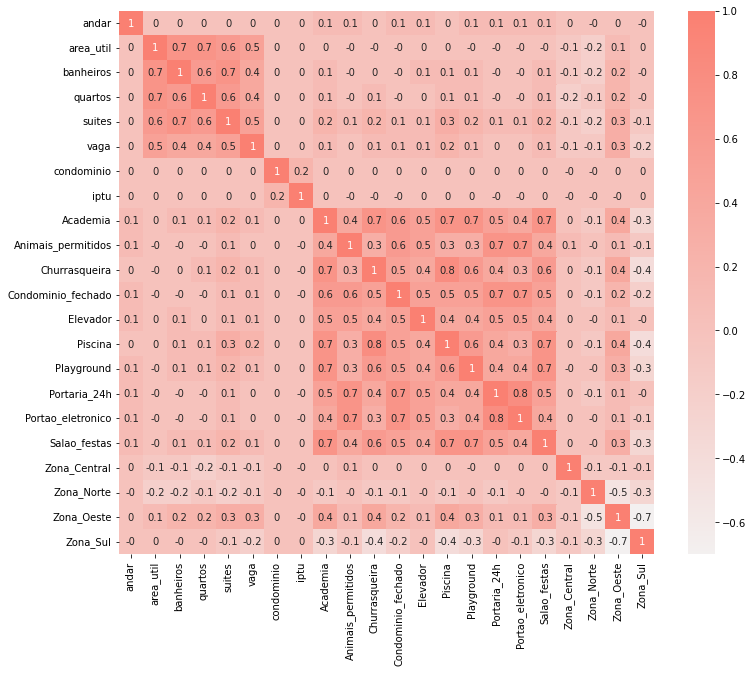

In [62]:
plt.figure(figsize = (12,10))
paleta = sns.color_palette('light:salmon', as_cmap = True)
sns.heatmap(dataframe_correlacao.round(1), annot = True, cmap = paleta)

#Regressão Linear

In [77]:
from pyspark.ml.regression import LinearRegression

In [78]:
treino, teste = dados_prep.randomSplit([0.7, 0.3], seed = 101)

In [79]:
treino.count()

46510

In [80]:
teste.count()

20052

In [81]:
lr = LinearRegression()

In [82]:
modelo_lr = lr.fit(treino)

In [83]:
modelo_lr_treino = modelo_lr.transform(treino)

Avaliação dos modelos

In [84]:
resumo_treino = modelo_lr.summary

In [85]:
resumo_treino.r2

0.6647068889109787

In [86]:
resumo_treino.rootMeanSquaredError

854711.2657380718

In [87]:
resumo_teste = modelo_lr.evaluate(teste)

In [88]:
resumo_teste.r2

0.6675078852679652

In [89]:
resumo_teste.rootMeanSquaredError

842737.2045493997

Tabela Resumo Regressão Linear

In [90]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.664707
RMSE: 854711.265738

Dados de Teste
R²: 0.667508
RMSE: 842737.204549


#Árvore de Decisão

In [91]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
     

In [92]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7) # Definição do modelo de árvore de decisão com profundidade igual a 7
modelo_dtr = dtr.fit(treino) #Ajuste do modelo
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [93]:
evaluator = RegressionEvaluator() # Criando avaliador de algoritmos de regressão
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [94]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.801438
RMSE: 657742.193410

Dados de Teste
R²: 0.764577
RMSE: 709129.988889


# Random Forest

In [95]:
from pyspark.ml.regression import RandomForestRegressor

In [96]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10) # Definição de alguns inputs como profunidade e o número de árvores
modelo_rfr = rfr.fit(treino)#Ajuste do modelo
previsoes_rfr_treino = modelo_rfr.transform(treino)
evaluator = RegressionEvaluator()

In [97]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [98]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.813013
RMSE: 638282.946321

Dados de Teste
R²: 0.795665
RMSE: 660651.766366


#Gradient Boost Trees Regressor

In [99]:
from pyspark.ml.regression import GBTRegressor

In [100]:
gbtr = GBTRegressor(maxDepth=7,seed=101)
modelo_gbtr = gbtr.fit(treino) #Ajuste do modelo
previsoes_gbtr_treino = modelo_gbtr.transform(treino)

In [101]:
evaluator = RegressionEvaluator()

In [102]:
previsoes_gbtr_teste = modelo_gbtr.transform(teste)

In [103]:
print('Gradient Boost Trees Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName: "rmse"}))

Gradient Boost Trees Regression
Dados de Treino
R²: 0.875065
RMSE: 521734.451125

Dados de Teste
R²: 0.802866
RMSE: 648907.070119


# Otimização de hiperparâmetros

Regressão Linear

In [126]:
lr = LinearRegression()

In [127]:
# Criando o grid com um intervalo de valores que serão utilizados no hiperparâmetros
grid = ParamGridBuilder()\
    .addGrid(lr.loss, ['squaredError', 'huber'])\
    .build()

In [128]:
# Criando o modelo com crossvalidation
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=101
)

In [129]:

# Ajustando o modelo aos dados
modelo_lr_cv = lr_cv.fit(treino)

In [130]:
# Prevendo resultados a partir dos dados de treino
previsoes_lr_cv_treino = modelo_lr_cv.transform(treino)

In [131]:
# Prevendo resultados a partir dos dados de teste
previsoes_lr_cv_teste = modelo_lr_cv.transform(teste)

In [133]:
print('Árvore de Decisão')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_lr_cv_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_lr_cv_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "rmse"}))

Árvore de Decisão
Sem Cross Validation
R²: 0.664707
RMSE: 854711.265738

Com Cross Validation
R²: 0.667508
RMSE: 842737.204549


Árvore de Decisão com Cross Validation

In [104]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [105]:
dtr = DecisionTreeRegressor()

In [106]:
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10])\
    .addGrid(dtr.maxBins, [10, 32, 45])\
    .build() # Definição dos hiperparametros a serem testado, 3x3, gerando 9 combinações a serem avaliadas

In [107]:
evaluator = RegressionEvaluator()
dtc_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
    )

In [108]:
modelo_dtc_cv = dtc_cv.fit(treino)

In [109]:
previsoes_dtr_cv_teste = modelo_dtc_cv.transform(teste)

In [110]:
print('Árvore de Decisão')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Árvore de Decisão
Sem Cross Validation
R²: 0.764577
RMSE: 709129.988889

Com Cross Validation
R²: 0.768476
RMSE: 703232.749922


Random Forest com Cross Validation



In [111]:
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor()

In [112]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 45]) \
    .build() # 8 Combinações de hiperparametros

In [113]:
evaluator = RegressionEvaluator()
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [114]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [115]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [116]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation
R²: 0.795665
RMSE: 660651.766366

Com Cross Validation
R²: 0.824596
RMSE: 612097.601342


Gradient-boosted Tree

In [136]:
gbtr = GBTRegressor()

In [137]:
grid = ParamGridBuilder()\
    .addGrid(gbtr.maxDepth, [5, 10])\
    .addGrid(gbtr.maxBins, [20, 32, 45])\
    .addGrid(gbtr.lossType, ['squared', 'absolute'])\
    .build()

In [138]:
gbtr_cv = CrossValidator(
    estimator = gbtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=101
)

In [139]:
modelo_gbtr_cv = gbtr_cv.fit(treino)

In [140]:
previsoes_gbtr_cv_treino = modelo_gbtr_cv.transform(treino)

In [141]:
previsoes_gbtr_cv_teste = modelo_gbtr_cv.transform(teste)

In [154]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_cv_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_cv_treino, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation
R²: 0.802866
RMSE: 648907.070119

Com Cross Validation
R²: 0.828047
RMSE: 612084.766324


# Tabela de Comparação dos Modelos

Para comparar o resultado dos modelos no final, será construido um DataFrame no pandas

In [117]:

modelos_resultado = {
    'modelo': [],
    'particao': [],
    'crossvalidation': [],
    'r2': [],
    'rmse': []
}

In [118]:
def adiciona_resultado(*args):
    for valor, resultado in zip(modelos_resultado.values(), args):
        valor.append(resultado)

In [119]:
modelos_resultado

{'modelo': [], 'particao': [], 'crossvalidation': [], 'r2': [], 'rmse': []}

In [121]:

# Adicionando resultados de regressão linear no dicionário
adiciona_resultado('linear_regression', 'treino', False, resumo_treino.r2, resumo_treino.rootMeanSquaredError)
adiciona_resultado('linear_regression', 'teste', False, resumo_teste.r2, resumo_teste.rootMeanSquaredError)

In [122]:
# Adicionando resultados de arvore de decisao no dicionário
adiciona_resultado('decision_tree', 'treino', False, evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName : 'rmse'}))
adiciona_resultado('decision_tree', 'teste', False, evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName : 'rmse'}))

In [124]:
# Adicionando resultados de random forest no dicionário
adiciona_resultado('random_forest', 'treino', False, evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName : 'rmse'}))
adiciona_resultado('random_forest', 'teste', False, evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName : 'rmse'}))

In [125]:
# Adicionando resultados de GBT no dicionário
adiciona_resultado('GBT', 'treino', False, evaluator.evaluate(previsoes_gbtr_treino, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_gbtr_treino, {evaluator.metricName : 'rmse'}))
adiciona_resultado('GBT', 'teste', False, evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName : 'rmse'}))

In [134]:
# Adicionando resultados  de regressao linear com cross validation no dicionário
adiciona_resultado('linear_regression', 'treino', True, evaluator.evaluate(previsoes_lr_cv_treino, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_lr_cv_treino, {evaluator.metricName : 'rmse'}))
adiciona_resultado('linear_regression', 'teste', True, evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName : 'rmse'}))

In [135]:
# Adicionando resultados de arvore de decisao com cross validation no dicionário
adiciona_resultado('decision_tree', 'treino', True, evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName : 'rmse'}))
adiciona_resultado('decision_tree', 'teste', True, evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName : 'rmse'}))

In [155]:
# Adicionando resultados no dicionário
adiciona_resultado('random_forest', 'treino', True, evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName : 'rmse'}))
adiciona_resultado('random_forest', 'teste', True, evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName : 'rmse'}))

In [143]:
# Adicionando resultados no dicionário
adiciona_resultado('GBT', 'treino', True, evaluator.evaluate(previsoes_gbtr_cv_treino, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_gbtr_cv_treino, {evaluator.metricName : 'rmse'}))
adiciona_resultado('GBT', 'teste', True, evaluator.evaluate(previsoes_gbtr_cv_teste, {evaluator.metricName : 'r2'}), 
                   evaluator.evaluate(previsoes_gbtr_cv_teste, {evaluator.metricName : 'rmse'}))

Comparando Modelos

In [156]:
# Criando DataFrame com o dicionário contendo os resultados dos modelos
df_resultado = pd.DataFrame(modelos_resultado)

In [157]:
# visualizando o DataFrame
df_resultado

,modelo,particao,crossvalidation,r2,rmse
0,linear_regression,treino,False,0.664707,854711.265738
1,linear_regression,teste,False,0.667508,842737.204549
2,decision_tree,treino,False,0.801438,657742.193410
3,decision_tree,teste,False,0.764577,709129.988889
4,random_forest,treino,False,0.813013,638282.946321
5,random_forest,teste,False,0.795665,660651.766366
6,random_forest,treino,False,0.813013,638282.946321
7,random_forest,teste,False,0.795665,660651.766366
8,GBT,treino,False,0.875065,521734.451125
9,GBT,teste,False,0.802866,648907.070119


In [158]:
# Multiplicando o r2 por 100 para transformá-lo em %
df_resultado['r2'] = df_resultado['r2'] * 100

In [159]:
# Definindo paleta de cores padrão do seaborn
sns.set()

In [160]:
# Criando um DataFrame para plotagem
df_plot = df_resultado.groupby('modelo')\
    .mean()\
    .reset_index()\
    .sort_values(by='r2')

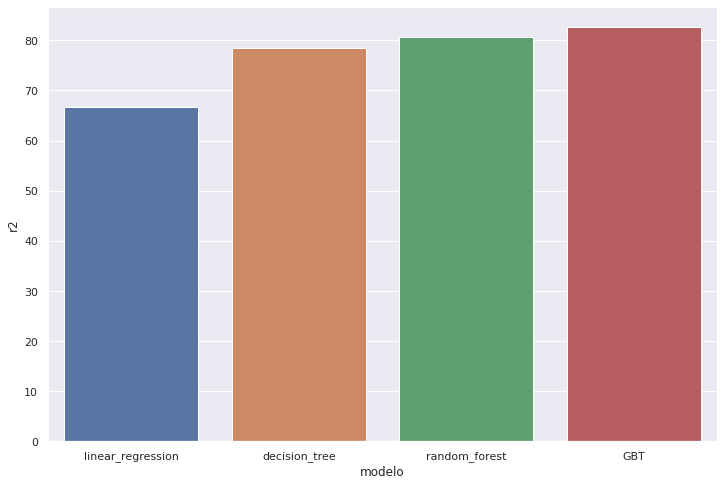

In [161]:
# Criando gráfico de barras com desempenho de cada modelo na métrica r2
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_plot, x='modelo', y='r2')

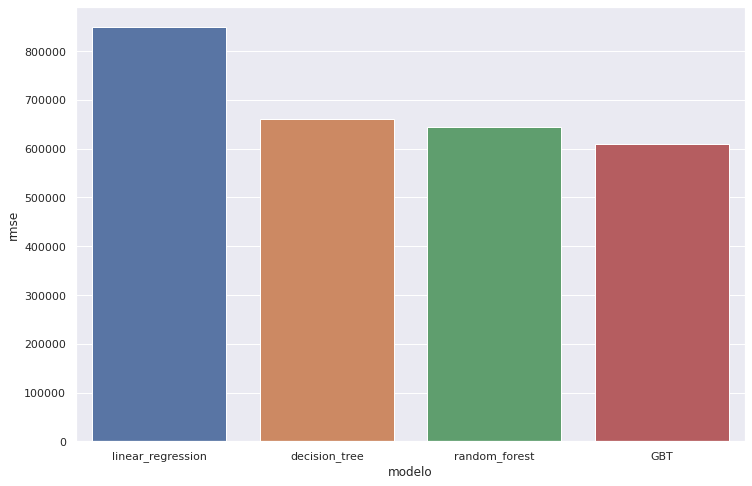

In [162]:

# Criando gráfico de barras com desempenho de cada modelo na métrica rmse
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_plot, x='modelo', y='rmse')

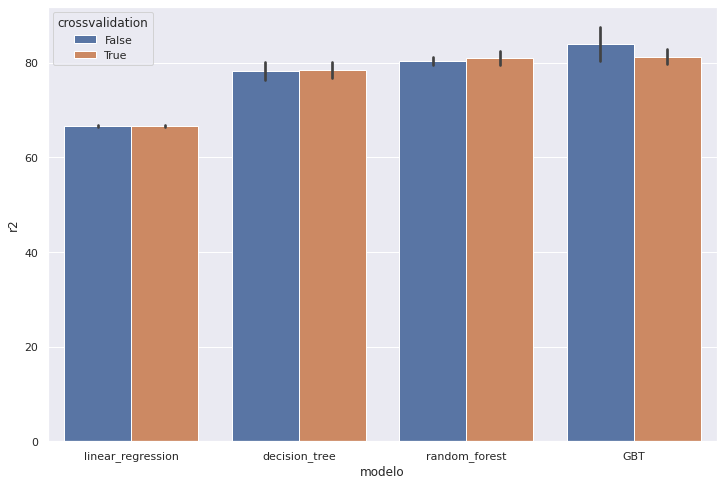

In [163]:
# Gráfico separado entre métricas retiradas de modelos com crossvalidation e sem
plt.figure(figsize=(12, 8))
sns.barplot(data=df_resultado, x='modelo', y='r2', hue='crossvalidation')